## Perform standard imports

In [ ]:
! pip install split-folders

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Define transforms

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Course Material/Supervised Machine Learning/Early Stopping Criterion for NN

## Prepare train and test sets, loaders

In [ ]:
splitfolders.ratio("Circle_Cross", output="OutPut",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 2001 files [00:01, 1100.42 files/s]


In [ ]:
train_data = datasets.ImageFolder('OutPut/train', transform = transform)
test_data = datasets.ImageFolder('OutPut/val', transform = transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True,  drop_last = True)
test_loader = DataLoader(test_data, batch_size= 32,  drop_last = True)

class_names = train_data.classes # classes or labels or categories

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['circles', 'crosses']
Training images available: 1599
Testing images available:  401


## Display a batch of images


In [ ]:
for images,labels in train_loader:
    break
images.shape

torch.Size([32, 3, 116, 116])

In [ ]:
labels

tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 1])

In [ ]:
test = len(test_data)
test

401

Label: [1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 1]
Class: crosses crosses circles circles crosses circles crosses crosses crosses crosses crosses circles crosses crosses crosses circles crosses circles circles circles crosses crosses circles circles crosses circles circles crosses circles circles crosses crosses


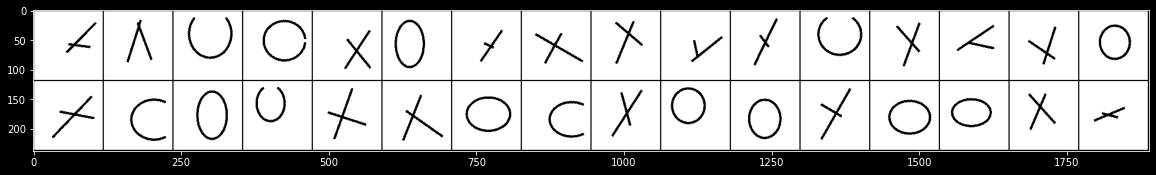

In [ ]:
# Print the labels

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=16)  # 16 images in a row. the default nrow is 8

# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0))); # we see that dataloader has shuffle the images

##  Create CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Defining Convolutional Layers

        self.conv1 = nn.Conv2d(3, 10, 5, 1, 1)
        # 3 = channel, 10 = number of kernels, 5 = kernel_size, 1 = Stride, 1 = padding
        self.conv2 = nn.Conv2d(10, 20, 5, 1, 1)

        # Definig Fully connected Layers

        #self.fc = nn.Linear(5*5*20, 64)
        self.fc = nn.LazyLinear(64)
        self.output = nn.Linear(64,2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        #X = X.view(-1, 5*5*20) # Infer the first dimension
        X = torch.flatten(X, 1) # Will be used with LazyLinear
        X = self.fc(X)
        X = F.relu(X)
        X = self.output(X)
        return X

In [ ]:
model = CNN()
model

D:\Anaconda\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


CNN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc): LazyLinear(in_features=0, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
# count the total number of parameters in the model
summary(model.cuda(),(3,116,116))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 114, 114]             760
            Conv2d-2           [-1, 20, 55, 55]           5,020
            Linear-3                   [-1, 64]         933,184
            Linear-4                    [-1, 2]             130
Total params: 939,094
Trainable params: 939,094
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.15
Forward/backward pass size (MB): 1.45
Params size (MB): 3.58
Estimated Total Size (MB): 5.19
----------------------------------------------------------------


# Setting Early Stopping Criterion

In [ ]:
class EarlyStoppingCriterion():
    def __init__(self, patience = 3, delta = 0,  trace_func = print):

        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Training and Testing the model

In [ ]:
  epochs = 500
  n_classes = 2
  batchsize = 32
  model.to(device)
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
# Instantiating the early stopping
  earlystopping = EarlyStoppingCriterion()


  # initialize losses
  losses    = torch.zeros(epochs)
  trainAcc  = []
  testAcc   = []
  test_losses =[]


  for epoch in range(epochs):
    model.train()

    # loop over training batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      ypred = model(X.float())
      loss = lossfun(ypred,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      ypred = ypred.cpu()
      y = y.cpu()

      # compute accuracy
      matches = torch.argmax(ypred,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append( accuracyPct )


    # Average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # Average losses across the batches
    losses[epoch] = np.mean(batchLoss)

    # test the model

    model.eval()

    with torch.no_grad(): # deactivates autograd
     batchAcc_test = []
     y_pred = np.zeros((test // batchsize , batchsize, n_classes))
     y_true = np.zeros((test // batchsize , batchsize))
     testbatch_losses = [] # This is new calculation

     for idx, (X,y) in enumerate(test_loader):

      X = X.to(device)
      y = y.to(device)
      ypred_t = model(X)
      ypred_t = ypred_t.cpu()
      y_pred[idx,:,:] = ypred_t
      y = y.cpu()
      y_true[idx,:] = y
      tloss = lossfun(ypred_t, y)
      # record test loss
      testbatch_losses.append(tloss.item())

      matches = torch.argmax(ypred_t,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc_test.append( accuracyPct )

    testAcc.append( np.mean(batchAcc_test) )
    test_losses.append( np.mean(testbatch_losses) )
    epoch_len = len(str(epochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +

                     f'test_loss: {np.mean(testbatch_losses):.5f}')

    print(print_msg)

    earlystopping(np.mean(testbatch_losses), model)

    if earlystopping.early_stop:
        print("Early stopping")
        break



[  0/500] test_loss: 0.68999
[  1/500] test_loss: 0.68679
[  2/500] test_loss: 0.68391
[  3/500] test_loss: 0.68075
[  4/500] test_loss: 0.67755
[  5/500] test_loss: 0.67379
[  6/500] test_loss: 0.66975
[  7/500] test_loss: 0.66506
[  8/500] test_loss: 0.65959
[  9/500] test_loss: 0.65337
[ 10/500] test_loss: 0.64635
[ 11/500] test_loss: 0.63811
[ 12/500] test_loss: 0.62834
[ 13/500] test_loss: 0.61601
[ 14/500] test_loss: 0.60113
[ 15/500] test_loss: 0.58699
[ 16/500] test_loss: 0.56957
[ 17/500] test_loss: 0.54993
[ 18/500] test_loss: 0.52775
[ 19/500] test_loss: 0.50504
[ 20/500] test_loss: 0.47686
[ 21/500] test_loss: 0.45101
[ 22/500] test_loss: 0.41564
[ 23/500] test_loss: 0.38235
[ 24/500] test_loss: 0.35181
[ 25/500] test_loss: 0.32100
[ 26/500] test_loss: 0.29536
[ 27/500] test_loss: 0.26851
[ 28/500] test_loss: 0.24599
[ 29/500] test_loss: 0.22525
[ 30/500] test_loss: 0.20793
[ 31/500] test_loss: 0.19439
[ 32/500] test_loss: 0.18038
[ 33/500] test_loss: 0.17201
[ 34/500] test

# Visualize the Model Performance

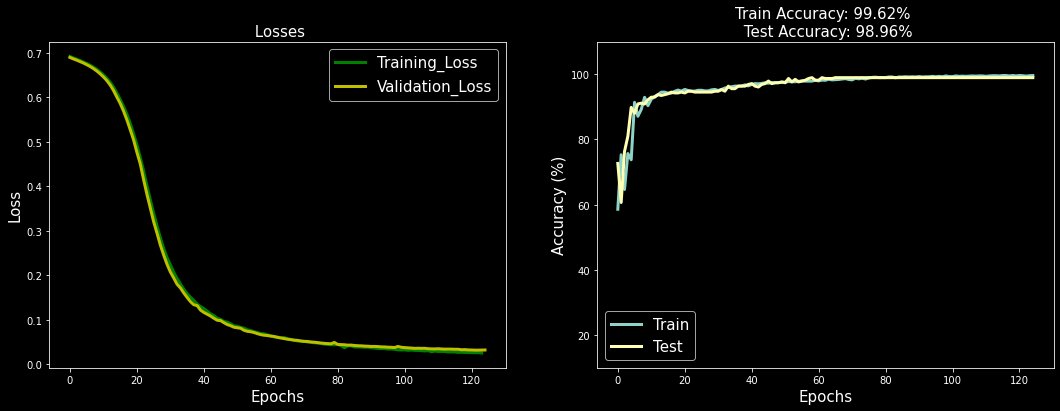

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses[0:epoch], 'g', lw = 3, label = 'Training_Loss')
ax[0].plot(test_losses, 'y', lw = 3, label = 'Validation_Loss')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title(' Losses', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()